<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_TF_simple
This is a bare minimum version of GREMLIN re-written to work with keras + tensorflow (v1 and v2).

For the old version of GREMLIN_TF_simple, that currently only works w/ tensorflow v1 [see here](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF1_simple.ipynb).

In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <koo@cshl.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

Select tensorflow version for Google Colab

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


## Load some libraries

In [0]:
import numpy as np
import matplotlib.pylab as plt
import string

## Convert FASTA to MSA np.array()

In [0]:
# Update 17Oct2019: 2X faster version of mk_msa() contributed by Ivan Anishchenko

def parse_fasta(filename, a3m=False):
  '''function to parse fasta file'''
  
  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))
    
  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      if a3m: line = line.translate(rm_lc)
      else: line = line.upper()
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return header, sequence
  
def mk_msa(seqs):
  '''one hot encode msa'''
  alphabet = list("ARNDCQEGHILKMFPSTWYV-")
  states = len(alphabet)
  
  alpha = np.array(alphabet, dtype='|S1').view(np.uint8)
  msa = np.array([list(s) for s in seqs], dtype='|S1').view(np.uint8)  
  for n in range(states):
    msa[msa == alpha[n]] = n  
  msa[msa > states] = states-1
  
  return np.eye(states)[msa]

## load example

In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [6]:
names, seqs = parse_fasta("4FAZA.fas")
msa = mk_msa(seqs)

print(msa.shape)

(817, 62, 21)


### compute weight for each sequence
if your alignment has many redundant sequences, these should be downweighted!
For example, if two sequences share more 80% identity, they are effectively one sequence, and thus each would get a weight of 0.5.

In [0]:
from scipy.spatial.distance import pdist, squareform
def get_eff(msa, eff_cutoff=0.8):
  if msa.ndim == 3: msa = msa.argmax(-1)    
  # pairwise identity  
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))
  # weight for each sequence
  msa_w = (msa_sm >= eff_cutoff).astype(np.float)
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

In [0]:
msa_weights = get_eff(msa)

## GREMLIN
GREMLIN is technically an "autoencoder" with a single dense (or fully-connected) layer between the input and output.
GREMLIN minimizes the difference between the input and output. The "latent" variables are the (w)eights/(b)ias of the dense layer.

* loss = categorical_crossentropy(msa,  softmax(dot(msa, w) + b))
 - the math is identical to computing the "pseudolikelihood" as in GREMLIN()
 
* msa
 - msa.shape = (batch, L x 21)
 - 21 =  (20 amino acids + 1 gap) categories
* w = weight
 - w.shape = (L x 21, L x 21)
 -  aka two-body term of the MRF (aka co-evolution)
 -  note: the w matrix is symmetrized and the diagional is set to zero
* b = bias 
 - b.shape = (L x 21)
 - aka one-body-term of the MRF (aka conservation)

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Zeros, Constant
from tensorflow.keras.losses import categorical_crossentropy

In [0]:
def GREMLIN_simple(msa, msa_weights=None, lam=0.01, 
                   opt=None, opt_rate=None,
                   opt_batch=None, opt_epochs=100):
  '''
  ------------------------------------------------------
  inputs
  ------------------------------------------------------
   msa         : msa input       shape=(N,L,A)
   msa_weights : weight per seq  shape=(N,)
  ------------------------------------------------------
  optional inputs
  ------------------------------------------------------
   lam         : L2 regularization weight
   opt         : optimizer
   opt_rate    : learning rate
   opt_batch   : batch size
   opt_epochs  : number of epochs
  ------------------------------------------------------
  outputs 
  ------------------------------------------------------
   v           : conservation    shape=(L,A)
   w           : coevolution     shape=(L,A,L,A)
  ------------------------------------------------------
  '''
  
  # [N]umber of sequences, [L]ength, and size of [A]lphabet
  N,L,A = msa.shape
    
  # reset any open sessions/graphs
  K.clear_session()
  
  #############################
  # the model
  #############################  
  
  # constraints
  def cst_w(x):
    '''symmetrize, set diagonal to zero'''
    x = (x + K.transpose(x))/2    
    zero_mask = K.constant((1-np.eye(L))[:,None,:,None],dtype=tf.float32)
    x = K.reshape(x,(L,A,L,A)) * zero_mask
    return K.reshape(x,(L*A,L*A))
  
  # initialiation
  if msa_weights is None:
    Neff = N
    pssm = msa.sum(0)
  else:
    Neff = msa_weights.sum()
    pssm = (msa.T*msa_weights).sum(-1).T
  
  ini_v = np.log(pssm + lam * np.log(Neff))
  ini_v = Constant(ini_v - ini_v.mean(-1,keepdims=True))
  ini_w = Zeros
  
  # regularization
  lam_v = l2(lam/N)
  lam_w = l2(lam/N * (L-1)*(A-1)/2)
  
  # model
  model = Sequential()
  model.add(Flatten(input_shape=(L,A)))
  model.add(Dense(units=L*A,
                  kernel_initializer=ini_w,
                  kernel_regularizer=lam_w,
                  kernel_constraint=cst_w,
                  bias_initializer=ini_v,
                  bias_regularizer=lam_v)) 
  model.add(Reshape((L,A)))
  model.add(Activation("softmax"))
  
  #############################
  # compile model
  #############################
  # loss function = CCE = -Pseudolikelihood
  @tf.function
  def CCE(true,pred):
    return K.sum(-true * K.log(pred + 1e-8),axis=(1,2))
  
  # optimizer settings
  if opt is None: opt = Adam
  if opt_rate is None: opt_rate = 0.1 * np.log(Neff)/L
  if opt_batch is None: opt_batch = N

  model.compile(opt(opt_rate),CCE)  
    
  #############################
  # fit model
  #############################
  model.fit(msa, msa, sample_weight=msa_weights,
            batch_size=opt_batch, epochs=opt_epochs,
            verbose=False)

  # report loss
  loss = model.evaluate(msa, msa, sample_weight=msa_weights, verbose=False) * N
  print(f"loss: {loss}")
  
  #############################
  # return weights
  #############################
  w,v = model.get_weights()
  return v.reshape((L,A)), w.reshape((L,A,L,A))

In [14]:
%%time
V, W = GREMLIN_simple(msa, msa_weights)

loss: 26911.78012466431
CPU times: user 2.68 s, sys: 283 ms, total: 2.96 s
Wall time: 3.3 s


## get contacts

In [0]:
def get_mtx(W):
  '''
  ------------------------------------------------------
  inputs
  ------------------------------------------------------
   w           : coevolution   shape=(L,A,L,A)
  ------------------------------------------------------
  outputs 
  ------------------------------------------------------
   raw         : l2norm(w)     shape=(L,L)
   apc         : apc(raw)      shape=(L,L)
  ------------------------------------------------------
  '''
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:-1,:,:-1]),(1,3)))

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return raw, apc

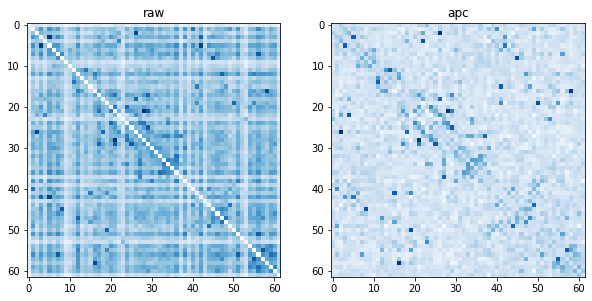

In [16]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(raw, cmap='Blues'); plt.title("raw")
plt.subplot(1,2,2); plt.imshow(apc, cmap='Blues'); plt.title("apc")
plt.show()

# NON SIMPLE FEATURES

### mod_adam
Modified adam optimizer for convex problems. We find this simple modification to the adam optimizer removed the need to guess/adjust the learning rate, and required far less steps for convergence.

In [0]:
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
class mod_adam(optimizer_v2.OptimizerV2):
  
  def __init__(self, learning_rate=0.5, b1=0.9, b2=0.999, name='mod_adam', **kwargs):
    super(mod_adam, self).__init__(name, **kwargs)
    self.rt, self.b1, self.b2 = learning_rate, b1, b2

  def _create_slots(self, var_list):
    for var in var_list: self.add_slot(var, 'm')
    for var in var_list: self.add_slot(var, 'v')

  def _resource_apply_dense(self, grad, var):
    m = self.get_slot(var, 'm')
    v = self.get_slot(var, 'v')
    m_tmp = self.b1 * m + (1 - self.b1) * grad
    v_tmp = self.b2 * v + (1 - self.b2) * tf.reduce_sum(tf.square(grad))
    l_tmp = self.rt / (tf.sqrt(v_tmp) + 1e-8)
    updates = [m.assign(m_tmp), v.assign(v_tmp), var.assign_add(-l_tmp * m_tmp)]
    return tf.group(updates)

  def get_config(self):
    return super(mod_adam, self).get_config()

In [18]:
%%time
V, W = GREMLIN_simple(msa, msa_weights, opt=mod_adam, opt_rate=0.5)

loss: 26871.985652923588
CPU times: user 2.3 s, sys: 171 ms, total: 2.48 s
Wall time: 1.96 s
